# Classification Methods in R

We're using the dataset from https://archive.ics.uci.edu/ml/datasets/Bank+Marketing

## Set up environment and required packages

The package *tidyverse* includes *dplyr, tidyr, readr, ggplot2*

In [59]:
library(tidyverse)
library(caret)
library(ROCR)

options(warn=-1)

## Load the data

In [61]:
data_dir <- "../data/"
data_set <- cat(data_dir,"bank-full.csv")
bank_data <- read.csv(data_set)

../data/ bank-full.csv

ERROR: Error in read.table(file = file, header = header, sep = sep, quote = quote, : 'file' must be a character string or connection


Let's briefly explore it

In [34]:
sprintf("# rows: %d - # columns: %d", nrow(bank_data), ncol(bank_data))
summary(bank_data)

[1] "# rows: 41188 - # columns: 21"

      age                 job            marital     
 Min.   :17.00   admin.     :10422   divorced: 4612  
 1st Qu.:32.00   blue-collar: 9254   married :24928  
 Median :38.00   technician : 6743   single  :11568  
 Mean   :40.02   services   : 3969   unknown :   80  
 3rd Qu.:47.00   management : 2924                   
 Max.   :98.00   retired    : 1720                   
                 (Other)    : 6156                   
               education        default         housing           loan      
 university.degree  :12168   no     :32588   no     :18622   no     :33950  
 high.school        : 9515   unknown: 8597   unknown:  990   unknown:  990  
 basic.9y           : 6045   yes    :    3   yes    :21576   yes    : 6248  
 professional.course: 5243                                                  
 basic.4y           : 4176                                                  
 basic.6y           : 2292                                                  
 (Other)            : 1749   

### Some minor data manipulation
Convert the 'yes'/'no' values of the label to 1/0

In [35]:
if (any(bank_data$y == "yes")) {
bank_data <- bank_data %>%
              mutate(y = ifelse(y=="yes", 1, 0))
}

## Partition the data in training and test set
We're using the simple 80/20 split

In [36]:
set.seed(4711)
partition <- createDataPartition(bank_data$y, p = 0.8, list=FALSE)

train.df <- bank_data[partition,]
test.df  <- bank_data[-partition,]

cat("Number of training samples :", nrow(train.df), "\n")
cat("Number of test samples     :", nrow(test.df), "\n")

Number of training samples : 32951 
Number of test samples     : 8237 


## Build the Model
Using the routine *glm* (generalized linear models)

In [37]:
mod.log <- glm(y ~ ., data = train.df, family=binomial)
summary(mod.log)


Call:
glm(formula = y ~ ., family = binomial, data = train.df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-6.0099  -0.2972  -0.1845  -0.1333   3.3757  

Coefficients: (1 not defined because of singularities)
                               Estimate Std. Error z value Pr(>|z|)    
(Intercept)                  -2.531e+02  4.247e+01  -5.959 2.54e-09 ***
age                           8.514e-04  2.738e-03   0.311  0.75579    
jobblue-collar               -2.470e-01  8.926e-02  -2.768  0.00565 ** 
jobentrepreneur              -1.223e-01  1.398e-01  -0.875  0.38158    
jobhousemaid                 -1.637e-01  1.715e-01  -0.955  0.33976    
jobmanagement                -1.077e-01  9.668e-02  -1.114  0.26527    
jobretired                    2.773e-01  1.199e-01   2.314  0.02069 *  
jobself-employed             -1.601e-01  1.326e-01  -1.208  0.22701    
jobservices                  -1.309e-01  9.618e-02  -1.361  0.17358    
jobstudent                    2.654e-01  1.237

## Evaluate on the test set

In [38]:
thresh.pred <-.5
probs <- predict(mod.log,newdata=test.df,type="response")

test.df <- test.df %>% 
            mutate(pred.log= ifelse(probs < thresh.pred ,0,1))

### Confusion Matrix

In [39]:
with(test.df, table(y, pred.log))

   pred.log
y      0    1
  0 7130  189
  1  550  368

### Classification Accuracy

In [54]:
accuracy = with(test.df, mean(y == pred.log))
cat("Classification Accuracy : ", format(100*accuracy,digits = 4), "%\n")

Classification Accuracy :  91.03 %


### ROC Curve

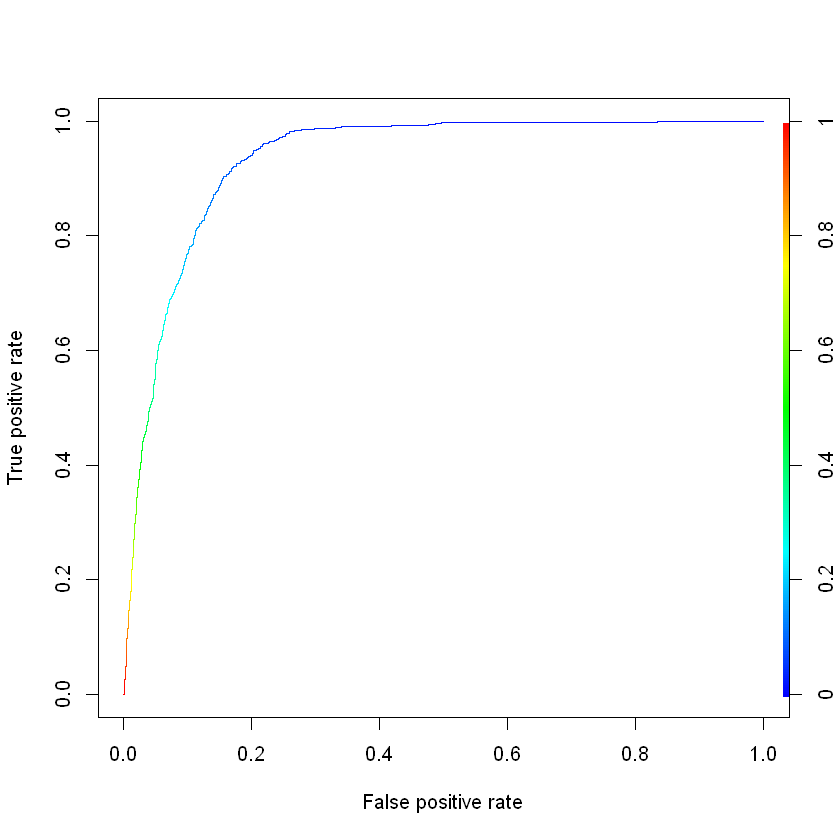

In [55]:
pred <- prediction( probs, test.df$y)
roc_perf <- performance(pred,"tpr","fpr")
plot(roc_perf, colorize=TRUE)

### Area under Curve (AUC)

In [58]:
auc_perf <- performance(pred,"auc")
auc <- auc_perf@y.values[[1]]
cat("AUC : ", format(auc,digits = 4), "\n")

AUC :  0.934 
